In [1]:
import pickle
import os, sys
import numpy as np
import matplotlib.pyplot as plt
os.chdir('../src')  # to avoid importing utils Anaconda package
from plot_utils import plot_maze_stats
from parameters import RewNames
from TDLambda_Home2Rwd_model import TDLambda_Home2Rwd
os.chdir('../TDLambda_Home2Rwd_stan')

model = TDLambda_Home2Rwd()

In [2]:
def revise_subfits(exclude=None):
    '''
    Exclude specific mice from analysis
    :param exclude: list of mouseIDs to exclude from simulations if their parameter fits didn't converge in STAN
    '''
    if exclude:
        for mouseID in exclude:
            org_sub_fits.pop(mouseID)
        sub_fits = dict(zip(np.arange(10-len(exclude)), org_sub_fits.values()))
    else:
        sub_fits = org_sub_fits
    real_mouseID = set(np.arange(10)) - set(exclude)
    
    return sub_fits, real_mouseID

# Loading real data
real_traj = pickle.load(open('traj_data/real_traj/rewMICE_post_firstR_every_Rvisit.pkl','rb'))
real_traj_lists = [traj[traj!=-1] for mouseID in np.arange(len(real_traj)) for traj in real_traj[mouseID]]

# Retrieving fitted subject parameters
org_sub_fits = pickle.load(open('results/TDlamda_Rvisit_real_init0.1/sub_fits.pkl','rb'))
sub_fits, real_mouseID = revise_subfits([0,2,8])

In [ ]:
avg_state_value_hist, _ = model.simulate_avg(sub_fits, RUNS=2, N_BOUTS_TO_GENERATE=100)

Results for mouse  B2 with fitted parameters: [0.04, 9.93, 0.87, 0.82]
Results for mouse  B4 with fitted parameters: [0.37, 9.92, 0.77, 0.89]
Results for mouse  C1 with fitted parameters: [0.53, 9.77, 0.78, 0.23]
Results for mouse  C3 with fitted parameters: [0.85, 9.87, 0.73, 0.24]
Results for mouse  C6 with fitted parameters: [0.78, 8.54, 0.75, 0.32]
Results for mouse  C7 with fitted parameters: [0.8, 8.74, 0.73, 0.58]
Results for mouse  C9 with fitted parameters: [0.85, 9.91, 0.73, 0.62]


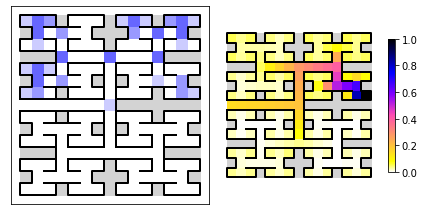

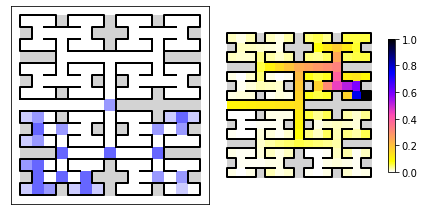

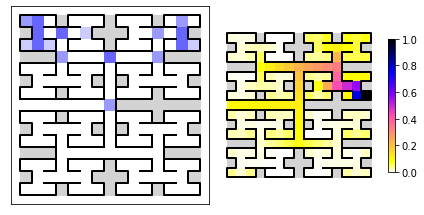

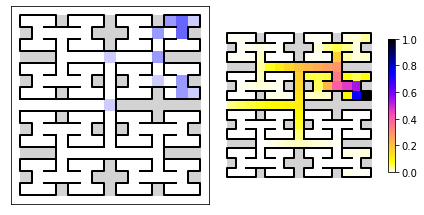

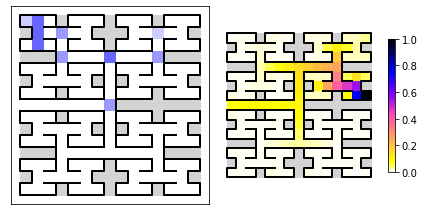

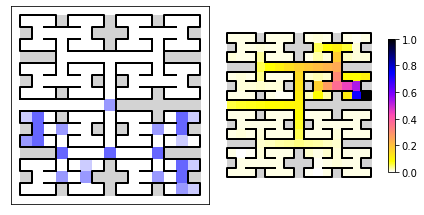

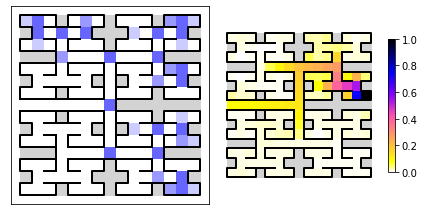

In [6]:
# Plotting frequency of real trajectories and average state values of predicted trajectories
for simID, realID in enumerate(real_mouseID):
    print('Results for mouse ', RewNames[realID], 'with fitted parameters:', str([np.round(val,2) for val in sub_fits[simID][:-1]]))
    
    # Arrange plots for a side-by-side comparison
    fig, (ax1, ax2) = plt.subplots(1,2)
    plot_maze_stats(real_traj_lists[realID], 'states', axes=ax1, display=False)
    plot_maze_stats(avg_state_value_hist[simID], 'state_values', 'gnuplot2_r', axes=ax2, display=False) # 'OrRd'